# Iterative Deepening A* (IDA*)


The need to store in memory the A* search tree (=CLOSED and OPEN 'lists') may become a bottleneck for some problems. One of such problems is the well-known n-puzzle (gem puzzle) game (especially when n>3). One of the ways to mitigate this problem is to use iterative deepening technique in combination with A\*. This is known as IDA\* algorithm (Korf, 1985).

In this lab your task is to implement IDA* algorithm for n-puzzle game and compare against A* (with the main indicators being runtime and memory consumption).

You will need to generate your own benchmark first. You may use random generation but don't forget to check the solvability of the generated instance (recall that not all n-puzzles are solvable).

Good luck!

(Korf, 1985) Korf, R.E., 1985. Depth-first iterative-deepening: An optimal admissible tree search. Artificial intelligence, 27(1), pp.97-109. https://academiccommons.columbia.edu/doi/10.7916/D8BK1M9V/download

In [1]:
import copy
import math
import matplotlib.pyplot as plt
import math
from random import shuffle
%matplotlib inline
%load_ext memory_profiler

## Representing the board state and the search state for the Gem Puzzle
- size - width of game field 
- tileList - tile positions represented as a list of integers. This list is expected to contain values from 1 to *size* * *size*. Each integer value corresponds to a tile and the position in the list (index) corresponds to the position of the tile on the game field. Tile with the value *size* * *size* is assumed to represent blank position.
- blankPos - position of empty tile in tileList. Explicitly storing the position of a blank helps to generate successors faster.

You may wish to come up with your own board state representation.


In [2]:
class GemPuzzleState:

    # Constructor. Sets tile positions + some basic checks.
    def __init__(self, tileList):
        self.tileList = tileList
        self.size = int(len(tileList) ** 0.5)
        blankValue = self.size ** 2
        if (blankValue != len(tileList)):
            raise Exception("The tile list must contain the number of elements which is equal to the square of an integer!")

        # Memorizing the position of a blank tile
        # Technically, there is no need to do so, but it makes to get the successors a bit faster
        self.blankPos = -1 
        for i in enumerate(tileList):
            if (i[1] == blankValue):
                self.blankPos = i[0]

        if (self.blankPos == -1):
            raise Exception("State should contains max value as position to blank tile")

    def __eq__(self, other):
        for a, b in zip(self.tileList, other.tileList):
            if a != b:
                return False
        return True

    # Printing the state as tile matrix
    def __str__(self):
        res = []
        charTileList = list(map(str, self.tileList))
        charTileList[self.blankPos] = '_'
        for rowStart in range(0, len(charTileList), self.size):
            res.append(charTileList[rowStart:rowStart+self.size])
        return '\n'.join([''.join(['{:2}'.format(item) for item in row]) for row in res]) + "\n"


## Search node

A wrapper for the GemPuzzleState that incorporates the data needed for the search algorithms (g-value, h-value, etc.).

In [3]:
class Node:
    def __init__(self, state, g = 0, h = 0, F = None, parent = None, k = 0):
        self.state = state
        self.state_str = str(state)
        self.g = g
        self.h = h
        self.k = k
        if F is None:
            self.F = self.g + h
        else:
            self.F = F
        self.parent = parent

    def __eq__(self, other):
        return self.state == other.state

    def __lt__(self, other):
        return self.F < other.F or ((self.F == other.F) and (self.h < other.h)) \
               or ((self.F == other.F) and (self.h == other.h) and (self.k > other.k))

## Succesors

Getting the succesors for the GemPuzzleState/SearchNode (both variants are OK, it's up to you).

Below is some basic implementation that you can modify/build upon.

In [4]:
def GetSuccessors(state):
    delta = [[0, 1], [1, 0], [0, -1], [-1, 0]]
    successors = []
    for d in delta:
        row = state.blankPos // state.size #identifying the row in which blank is located
        col = state.blankPos % state.size #identifying the column in which blank is located
        row += d[0] #computing new row for blank (corresponding to a particular move encoded via 'd')
        col += d[1] #computing new column for blank (corresponding to a particular move encoded via 'd')
        
        #if the new position of a blank is valid (i.e. it is still within the field) then
        #a corresponding sucessor should be added to the succesors' list
        if (0 <= row < state.size) and (0 <= col < state.size):
            newState = copy.deepcopy(state)
            newBlankPos = row * state.size + col
            newState.tileList[newState.blankPos] = newState.tileList[newBlankPos] #moving tile
            newState.tileList[newBlankPos] = newState.size ** 2 #setting blank
            newState.blankPos = newBlankPos

            successors.append(newState)

    return successors

## Heuristics Search
### OPEN and CLOSED 'lits' implementation

In [5]:
import heapq

class Open:
    def __init__(self):
        self.heap = []
        self.nodes = {}

    def __iter__(self):
        return iter(self.nodes.values())

    def __len__(self):
        return len(self.nodes)

    def is_empty(self):
        return len(self) == 0

    def add_node(self, node: Node, *args):
        pos = node.state_str
        if pos in self.nodes:
            if self.nodes[pos].g <= node.g:
                return
        self.nodes[pos] = node
        heapq.heappush(self.heap, node)

    def get_best_node(self, *args):
        while True:
            best = self.heap[0]
            heapq.heappop(self.heap)
            pos = best.state_str
            if pos in self.nodes:
                break
        del self.nodes[pos]
        return best

In [6]:
class Closed:
    def __init__(self):
        self.nodes = {}

    def __iter__(self):
        return iter(self.nodes.values())

    def __len__(self):
        return len(self.nodes)

    def add_node(self, item):
        self.nodes[item.state_str] = item

    def was_expanded(self, item):
        return item.state_str in self.nodes


### Heuristics
You need to implement 2 most common *admissible* heuristic functions for the n-puzzle.
- Hamming distance (the number of the misplaced tiles on the board).
- Manhattan distance (Google it).

In [7]:
def HammingDistance(puzzleState1, puzzleState2):
    res = 0
    for a, b in zip(puzzleState1.tileList, puzzleState2.tileList):
        if a != b:
            res += 1
    return res - 1


In [8]:
def ManhattanDistance(puzzleState1, puzzleState2):
    pos = dict()
    for i in range(puzzleState1.size):
        for j in range(puzzleState1.size):
            cur = puzzleState1.tileList[i * puzzleState1.size + j]
            pos[cur] = (i, j)
    res = 0
    for i in range(puzzleState2.size):
        for j in range(puzzleState2.size):
            cur = puzzleState2.tileList[i * puzzleState2.size + j]
            if cur == puzzleState2.size ** 2:
                continue
            res += (abs(pos[cur][0] - i) + abs(pos[cur][1] - j))
    return res


### A* algorithm
The output of the algorithm should likely be:
- path found flag (boolean)
- path cost
- number of expansions (=steps) an algorithm have made until reaching the solution
- number of created (and stored in the memory) nodes (=memory usage)

In [9]:
def AStar(startState, goalState, heuristicFunction = ManhattanDistance):
    OPEN = Open()
    CLOSED = Closed()
    h = heuristicFunction(startState, goalState)
    start_node = Node(startState, h=h)
    OPEN.add_node(start_node)
    cnt = 1
    steps = 0

    while not OPEN.is_empty():
        v = OPEN.get_best_node()
        CLOSED.add_node(v)
        steps += 1
        if v.state == goalState:
            return True, v.g, steps, cnt
        for nxt_state in GetSuccessors(v.state):
            h = heuristicFunction(nxt_state, goalState)
            nxt_node = Node(nxt_state, v.g + 1, h, parent=v)
            if not CLOSED.was_expanded(nxt_node):
                OPEN.add_node(nxt_node)
                cnt += 1

    return False, 0, steps, cnt

### IDA* algorithm

Implement IDA* algorithm. 

No other nodes except the ones forming the current path in the search tree have to be memorized.

Checking whether the generated successor have already been encountered on a currently explored path is OK.

The output of the algorithm should be analogous to A*.

In [10]:
def IDAStar(startState, goalState, heuristicFunction = ManhattanDistance):
    def walk(state, path, g, max_F, steps):
        steps += 1
        d = 1
        h = heuristicFunction(state, goalState)
        if g + h > max_F:
            return False, g + h, steps, d
        if state == goalState:
            return True, g, steps, d
        new_F = -1
        for nxt_state in GetSuccessors(state):
            nxt_str = str(nxt_state)
            if nxt_str in path:
                continue
            path.add(nxt_str)
            found, _F, steps, _d = walk(nxt_state, path, g + 1, max_F, steps)
            d = max(d, _d + 1)
            if found:
                return True, _F, steps, d
            new_F = _F if new_F == -1 else min(new_F, _F)
            path.remove(nxt_str)
        return False, new_F, steps, d

    cur_F = heuristicFunction(startState, goalState)
    path = {str(startState)}
    steps = 0
    d = 1
    while True:
        found, cur_F, steps, _d = walk(startState, path, 0, cur_F, steps)
        d = max(d, _d + 1)
        if found:
            return True, cur_F, steps, d
        if cur_F == -1:
            return False, 0, steps, d

## Generating Test Instances
Sample instances are available in the `Data/taskGem.txt`.

You need to create and add to the file (or replace) at least **30** additional instances (8-puzzle) for running experiments. You may use random generation. Depending on how you generate puzzles you may need checking the solvability of each generated instance (recall, that not all n-puzzles are solvable).

In [11]:
def IsSolvable(tileList):
    inversions = 0
    empty_pos = 0
    puzzleExeptEmpty = []
    for i, v in enumerate(tileList):
        if v != len(tileList):
            puzzleExeptEmpty.append((i, v))
        else:
            empty_pos = i

    for i, tile in puzzleExeptEmpty:
        j = i + 1
        while j < len(tileList):
            if tileList[j] < tile:
                inversions += 1
            j += 1
    
    size = int(math.sqrt(len(tileList)))
    
    if size % 2 != 0 and inversions % 2 == 0:
        return True

    if size % 2 == 0:
        emptyrow = size - empty_pos // size
        return (emptyrow % 2 != 0) == (inversions % 2 == 0)

    return False

In [12]:
import numpy as np

def GenerateTasks(taskFile, number, size, seed=None):
    if seed is not None:
        np.random.seed(seed)
    with open(taskFile, 'w') as f:
        for _ in range(number):
            while True:
                tiles = np.random.permutation(size ** 2) + 1
                if IsSolvable(tiles):
                    f.write(' '.join(tiles.astype(str)))
                    f.write('\n')
                    break

In [13]:
# Generating 30 instances for 3x3 puzzle
GenerateTasks('Data/tasksGem.txt', 30, 3, seed=42)

You will likely to need a procedure that takes a search algorithm and a heuristic function (e.g. IDA* + Manhattan distance) as parameters, runs tests and stores the results for further analysis. So, go ahead and code it.


In [14]:
from tqdm.notebook import tqdm

def MassiveTest(stats, SearchFunction, *args):
    stats['found'] = []
    stats['cost'] = []
    stats['steps'] = []
    stats['nodes'] = []
    tasks = []
    with open('Data/tasksGem.txt') as f:
        for line in f:
            tiles = list(map(int, line.split()))
            startState = GemPuzzleState(tiles)
            goalState = GemPuzzleState(range(1, len(tiles) + 1))
            tasks.append((startState, goalState))
    for startState, goalState in tqdm(tasks):
        found, cost, steps, nodes = SearchFunction(startState, goalState, *args)
        stats['found'].append(found)
        stats['cost'].append(cost)
        stats['steps'].append(steps)
        stats['nodes'].append(nodes)
    stats['found'] = np.array(stats['found'])
    stats['cost'] = np.array(stats['cost'])
    stats['steps'] = np.array(stats['steps'])
    stats['nodes'] = np.array(stats['nodes'])

## Experiment
Run `A*` and `IDA*` with different heuristics on the generated instances and collect the results for further analysis.

In [15]:
#Running A* with Hamming Distance on the generated datase (and collecting the statistics)

stats_a_ham = dict()
%time %memit MassiveTest(stats_a_ham, AStar, HammingDistance)

  0%|          | 0/30 [00:00<?, ?it/s]

peak memory: 129.24 MiB, increment: 51.50 MiB
Wall time: 28 s


In [16]:
#Running A* with Manhattan Distance on the generated datase (and collecting the statistics)

stats_a_man = dict()
%time %memit MassiveTest(stats_a_man, AStar, ManhattanDistance)

  0%|          | 0/30 [00:00<?, ?it/s]

peak memory: 85.12 MiB, increment: 0.23 MiB
Wall time: 3.16 s


In [17]:
#Running IDA* with Hamming Distance on the generated datase (and collecting the statistics)

stats_ida_ham = dict()
%time %memit MassiveTest(stats_ida_ham, IDAStar, HammingDistance)

  0%|          | 0/30 [00:00<?, ?it/s]

peak memory: 83.36 MiB, increment: 0.02 MiB
Wall time: 2min 50s


In [18]:
#Running IDA* with Manhattan Distance on the generated datase (and collecting the statistics)

stats_ida_man = dict()
%time %memit MassiveTest(stats_ida_man, IDAStar, ManhattanDistance)

  0%|          | 0/30 [00:00<?, ?it/s]

peak memory: 83.03 MiB, increment: 0.01 MiB
Wall time: 6.06 s


## Analisys 
Analyze the obtained results and vizualize them as plots/tables. Write a short report in the separate cell.

A* Hamming found: 1.0
A* Manhattan found: 1.0
IDA* Hamming found: 1.0
IDA* Manhattan found: 1.0
Respect solution: True
A* Hamming steps: 12748.733333333334
A* Manhattan steps: 877.8333333333334
IDA* Hamming steps: 170863.6
IDA* Manhattan steps: 4087.4666666666667
A* Hamming nodes: 20184.833333333332
A* Manhattan nodes: 1422.3333333333333
IDA* Hamming nodes: 23.966666666666665
IDA* Manhattan nodes: 23.966666666666665


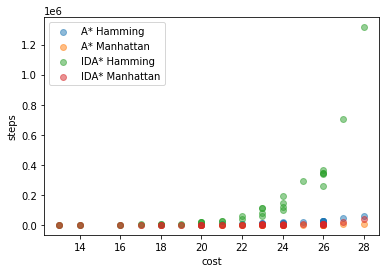

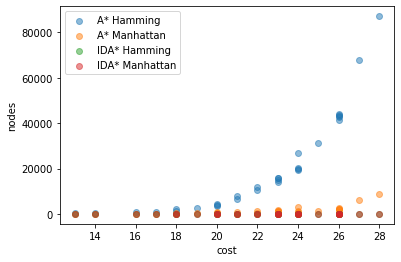

In [19]:
print('A* Hamming found:', np.mean(stats_a_ham['found']))
print('A* Manhattan found:', np.mean(stats_a_man['found']))
print('IDA* Hamming found:', np.mean(stats_ida_ham['found']))
print('IDA* Manhattan found:', np.mean(stats_ida_man['found']))

respect = np.all(stats_a_man['cost'] == stats_a_ham['cost']) and \
          np.all(stats_a_man['cost'] == stats_ida_man['cost']) and \
          np.all(stats_a_man['cost'] == stats_ida_ham['cost'])
print('Respect solution:', respect)

print('A* Hamming steps:', np.mean(stats_a_ham['steps']))
print('A* Manhattan steps:', np.mean(stats_a_man['steps']))
print('IDA* Hamming steps:', np.mean(stats_ida_ham['steps']))
print('IDA* Manhattan steps:', np.mean(stats_ida_man['steps']))

print('A* Hamming nodes:', np.mean(stats_a_ham['nodes']))
print('A* Manhattan nodes:', np.mean(stats_a_man['nodes']))
print('IDA* Hamming nodes:', np.mean(stats_ida_ham['nodes']))
print('IDA* Manhattan nodes:', np.mean(stats_ida_man['nodes']))


plt.scatter(stats_a_ham['cost'], stats_a_ham['steps'], alpha=0.5, label='A* Hamming')
plt.scatter(stats_a_man['cost'], stats_a_man['steps'], alpha=0.5, label='A* Manhattan')
plt.scatter(stats_ida_ham['cost'], stats_ida_ham['steps'], alpha=0.5, label='IDA* Hamming')
plt.scatter(stats_ida_man['cost'], stats_ida_man['steps'], alpha=0.5, label='IDA* Manhattan')
plt.xlabel('cost')
plt.ylabel('steps')
plt.legend(loc='upper left')
plt.show()

plt.scatter(stats_a_ham['cost'], stats_a_ham['nodes'], alpha=0.5, label='A* Hamming')
plt.scatter(stats_a_man['cost'], stats_a_man['nodes'], alpha=0.5, label='A* Manhattan')
plt.scatter(stats_ida_ham['cost'], stats_ida_ham['nodes'], alpha=0.5, label='IDA* Hamming')
plt.scatter(stats_ida_man['cost'], stats_ida_man['nodes'], alpha=0.5, label='IDA* Manhattan')
plt.xlabel('cost')
plt.ylabel('nodes')
plt.legend(loc='upper left')
plt.show()

Как и ожидалось используемая память в IDA* гораздо меньше, чем в A* , но A* работает быстрее.

Если сравнивать эвристики, то видно, что Manhattan сильно лучше Hamming.

## The last but not the least 

lets measure the 'real' memory consumption (in Megabytes) of A* vs IDA* on some non-trivial instance.

In [20]:
#to measure the memory consumtion in absolute values you can use the 'memory_profiler' package (you may need installation)
%reload_ext memory_profiler

In [21]:
startTileListStr = "1 2 10 8 12 14 6 4 15 13 5 3 9 7 11 16"
startTileList = list(map(int, startTileListStr.split()))
goalTileList = list(range(1, len(startTileList) + 1))
startState = GemPuzzleState(startTileList)
goalState = GemPuzzleState(goalTileList)

In [22]:
#This should take some time (3-10 minutes depending on your hardware), 
#and the memory consumption should be around 1400-1500Mb (sic!)
%time %memit AStar(startState, goalState, ManhattanDistance)

peak memory: 517.66 MiB, increment: 432.47 MiB
Wall time: 48.6 s


In [23]:
#This should take a bit longer time, 
#but the memory consumption should be much (much!) lower.
%time %memit IDAStar(startState, goalState, ManhattanDistance)

peak memory: 92.47 MiB, increment: 0.01 MiB
Wall time: 3min 20s
